# Building your own optimization

## Adding Optimization Passes to the Pass Stack<a class="anchor" id="optimization_passes"></a>

## General Passes

Before reading this section, we will briefly explain how passes work.
There are five kinds of passes:
1. **AST transformation passes** - These passes convert the input program into AST.
2. **semantic checks passes** - These passes check the corectness of the program (i.e. one of the passes asserts that all the relations used in the program were registerred before).
3. **AST execution passes** - These passes traverse the AST and covert it to a `parse graph`. In addition they register new relations and handle variables assingments.
4. **term graph passes** - These passes adds rules into the `term graph`.
5. **execution pass** - This pass traverses the `parse graph` and finds queries. Then it computes them using the `term graph`.

## Optimization Passes

There are two kinds of optimization passes:
1. The first one, manipulates rules before they are added to the `term graph`.
2. The second one, manipulates the structure of the `term graph`.

note: It's also possible to optimize the execution function/pass (but we won't discuss it in this tutorial). 
    
In this section, we will implement two simple optimization passes, one of each kind.

## Rule-Manipulation Optimization

Optimizations of  this kind traverse the `parse_graph` and find rules that weren't added to the `term graph`.
Then, they update each rule - by modifying its body relations list.

Here are some examples of possible optimization passes of this kind:
1. An optimization that removes duplicated relations from a rule.
   i.e., the rule `A(X) <- B(X), C(X), B(X)` contains the relation `B(X)` twice.
   The optimization will transform the rule into `A(X) <- B(X), C(X)`.
   
2. An optimization that removes useless relations from a rule.
   i.e. the rule `A(X) <- B(X), C(Y)` contains the useless relation `C(Y)`.
   The optimization will transform the rule into `A(X) <- B(X)`.
   
Below is an implementation of the latter example:

### Optimization Example: Remove Useless Relations

Before jumping into the actual implementation, we will implement it in psuedo code:
```
1. a. Add the free variables inside the rule head into a relevant_free_variables set.
   b. Mark all relations as useless, except those with no free variables (they are always relevant).
   
2. Find all relations which contain at least one free variable inside the relevant_free_variables set.

3. Unmark these relations (since they are relevant).

4. Add all free variables of the unmarked relations into the relevant_free_variables set.

5. Repeat steps 2, 3 and 4 until the set of the marked relations converge.
```
note that this is a ```fixed_point``` algorithm.

In [ ]:
from spanner_workbench.general_utils import fixed_point
from spanner_workbench.general_utils import get_output_free_var_names
from spanner_workbench.general_utils import get_input_free_var_names

Installation NLP failed
cargo or rustup are not installed in $PATH. please install rust: https://rustup.rs/


```get_output_free_var_names``` documentation
```get_input_free_var_names``` documentation

In [ ]:
# first, lets implement the logic that removes useless relations from a rule
def remove_useless_relations(rule):
        """
        Finds redundant relations and removes them from the rule.
        
        @param rule: a rule.
        """
        # step 1.a. Add the free variables inside the rule head into a relevant_free_variables set.
        relevant_free_vars = set(rule.head_relation.get_term_list())  

        # step 1.b. Mark all relations as useless, except those with no free variables (they are always relevant).
        initial_useless_relations_and_types = [(rel, rel_type) for rel, rel_type in zip(rule.body_relation_list, rule.body_relation_type_list)
                                               if len(get_output_free_var_names(rel)) != 0]
        # implement steps 2, 3 and 4
        def step_function(current_useless_relations_and_types):
            """
            Used by fixed pont algorithm.

            @param current_useless_relations_and_types: current useless relations and their types
            @return: useless relations after considering the new relevant free vars.
            """

            next_useless_relations_and_types = []
            
            # step 2 - Find all relations that has at least on free variable inside the relevant_free_variables set.
            for relation, rel_type in current_useless_relations_and_types:
                term_list = get_output_free_var_names(relation)
                if len(relevant_free_vars.intersection(term_list)) == 0:
                    next_useless_relations_and_types.append((relation, rel_type))
                else:
                    # step 3 - Unmark relation. The relations isn't added to the useless list, and thus it's unmarked.
                    # step 4 - Add all the free variables of the unmarked relation into the relevant_free_variables set.
                    relevant_free_vars.update(term_list)
                    relevant_free_vars.update(get_input_free_var_names(relation))

            return next_useless_relations_and_types

        # step 5 - fixed ponint. note that the distance function returns zero if and only if len(x) equals len(y).
        useless_relations_and_types = fixed_point(start=initial_useless_relations_and_types, step=step_function, distance=lambda x, y: int(len(x) != len(y)))
        
        # this part filters the useless relation from the rule
        relevant_relations_and_types = set(zip(rule.body_relation_list, rule.body_relation_type_list)).difference(useless_relations_and_types)
        new_body_relation_list, new_body_relation_type_list = zip(*relevant_relations_and_types)
        rule.body_relation_list = list(new_body_relation_list)
        rule.body_relation_type_list = list(new_body_relation_type_list)

In [ ]:
from spanner_workbench.graphs import GraphBase, EvalState, STATE, TYPE, VALUE
from spanner_workbench.passes_utils import ParseNodeType
from spanner_workbench.lark_passes import GenericPass  # base class of all the passes
    

# finally, the implementation of the optimization pass
class RemoveUselessRelationsFromRule(GenericPass):
    """
    This pass removes duplicated relations from a rule.
    For example, the rule A(X) <- B(X), C(Y) contains a redundant relation (C(Y)).
    After this pass the rule will be A(X) <- B(X).

    @note: in the rule A(X) <- B(X, Y), C(Y); C(Y) is not redundant!
    """
    
    def __init__(self, parse_graph: GraphBase, **kwargs):
        self.parse_graph = parse_graph
            
    def run_pass(self, **kwargs):
        # get the new rules in the parse graph
        rules = self.parse_graph.get_all_nodes_with_attributes(type=ParseNodeType.RULE, state=EvalState.NOT_COMPUTED)
        for rule_node_id in rules:
            rule_node = self.parse_graph[rule_node_id]
            rule = rule_node[VALUE]
            remove_useless_relations(rule)

Modifying the pass stack looks like this:

In [ ]:
#| hide
from spanner_workbench import Session

In [ ]:
def print_pass_stack(pass_stack):
    """prints pass stack in a nice format"""
    
    for pass_ in pass_stack:
        print("\t" + pass_.__name__)
        
magic_session = Session()  # reset the magic session

original_pass_stack = magic_session.get_pass_stack()  # save the original pass stack

new_pass_stack = original_pass_stack.copy()
term_graph_pass = new_pass_stack.pop()  # remove last pass (this pass adds rules to term graph)
new_pass_stack.extend([RemoveUselessRelationsFromRule, term_graph_pass])

magic_session.set_pass_stack(new_pass_stack)

print(f"Pass stack before:")
print_pass_stack(original_pass_stack)

print("\nPass stack after:")
print_pass_stack(magic_session.get_pass_stack())

Pass stack before:
	RemoveTokens
	FixStrings
	CheckReservedRelationNames
	ConvertSpanNodesToSpanInstances
	ConvertStatementsToStructuredNodes
	CheckDefinedReferencedVariables
	CheckReferencedRelationsExistenceAndArity
	CheckReferencedIERelationsExistenceAndArity
	CheckRuleSafety
	TypeCheckAssignments
	TypeCheckRelations
	SaveDeclaredRelationsSchemas
	ResolveVariablesReferences
	ExecuteAssignments
	AddStatementsToNetxParseGraph
	AddRulesToTermGraph

Pass stack after:
	RemoveTokens
	FixStrings
	CheckReservedRelationNames
	ConvertSpanNodesToSpanInstances
	ConvertStatementsToStructuredNodes
	CheckDefinedReferencedVariables
	CheckReferencedRelationsExistenceAndArity
	CheckReferencedIERelationsExistenceAndArity
	CheckRuleSafety
	TypeCheckAssignments
	TypeCheckRelations
	SaveDeclaredRelationsSchemas
	ResolveVariablesReferences
	ExecuteAssignments
	AddStatementsToNetxParseGraph
	RemoveUselessRelationsFromRule
	AddRulesToTermGraph


Now let's look at the effect of this pass on the parse graph:

In [ ]:
commands = """
new Good(int)
new Bad(int)

Example(X) <- Good(X), Bad(Y)
"""

def run_commands_and_print_parse_graph(session):
    session.run_commands(commands)
    print(session._parse_graph)
    

print("Parse graph of unmodified pass stack:\n")
run_commands_and_print_parse_graph(Session()) 

print("\nParse graph after adding optimization pass:\n")
run_commands_and_print_parse_graph(magic_session) 

Parse graph of unmodified pass stack:

(__spanner_workbench_root) (computed) root
    (0) (computed) relation_declaration: Good(int)
    (1) (computed) relation_declaration: Bad(int)
    (2) (computed) rule: Example(X) <- Good(X), Bad(Y)


Parse graph after adding optimization pass:

(__spanner_workbench_root) (computed) root
    (0) (computed) relation_declaration: Good(int)
    (1) (computed) relation_declaration: Bad(int)
    (2) (computed) rule: Example(X) <- Good(X)



Notice the difference in the rule node!

## Term Graph Structure Optimization

Optimizations of this kind traverse the `term_graph` and modify its structure.

## Term Graph Structure
Before reading on, it is important to understand how the ```TermGraph``` looks like in order to understand the terminology used - there is detailed documentation inside the class docstring.

## Structure Optimization
Here are some examples of possible optimization passes of this kind:
1. An optimization that removes join nodes which have only one child relation.
   Note: this optimization already exists so there is no need to implement it.
   
2. An optimization that removes project nodes whose input is a single-column relation.
   
Here's the implementation of the second example:

## Optimization Example: Remove Redundant Project Nodes

The following optimization will traverse the term graph and find all project nodes that has input relation with arity of one.<br>
In this case, the project node is redundant and therefore, we remove it from the term graph.

Before jumping into the actual implementation, we will implement it in a psuedo code:
```
1. Find all project nodes and their union nodes parents (inside the term graph).

2. For each project node

    2.1. Check if the arity of the project node's input relation is one, using the following steps:
        a. get project's node child - we will denote it as child_node.
        b. if type of child_node is GET_REL or RULE_REL or CALC node child, return true if arity of the relation stored in child_node is one.
        c. if type of child_node is SELECT, return true if there is only one free variable in the relation stored in the child of the child_node. 
        d. if type of child_node is project:
              (i). get input relaations from all of it's children nodes
              (ii). return true if the arity of the join of all the input relations is one.
              
    2.2 if has arity of one, remove the node from the graph by connecting it's child to it's parent.
```

In [ ]:
# helper function
def is_relation_has_one_free_var(relation) -> bool:
    """
    Check whether relation is only one free variable.

    @param relation_: a relation or an ie_relation.
    """

    return len(relation.get_term_list()) == 1

In [ ]:
from spanner_workbench.graphs import *
# this function implements step 2 in the pseudo code
def is_input_relation_of_node_has_arity_of_one(term_graph: TermGraphBase, node_id) -> bool:
    """
    @param node_id: id of the node.
    @note: we expect id of project/join node.
    @return: the arity of the relation that the node gets during the execution.
    """

    # staep 2.1.a: note that this methods suppose to work for both project nodes and join nodes.
    # project nodes always have one child while join nodes always have more than one child.
    # for that reason, we traverse all the children of the node.
    node_ids = term_graph.get_children(node_id)
    
    # used to compute arity of final relation
    free_vars: Set[str] = set()

    for node_id in node_ids:
        node_attrs = term_graph[node_id]
        node_type = node_attrs[TYPE]
        
        # step 2.1.b
        if node_type in (TermNodeType.GET_REL, TermNodeType.RULE_REL, TermNodeType.CALC):
            relation = node_attrs[VALUE]
            # if relation has more than one free var we can't prune the project
            if not is_relation_has_one_free_var(relation):
                return False

            free_vars |= set(relation.get_term_list())
            
        # step 2.1.c
        elif node_type is TermNodeType.SELECT:
            relation_child_id = next(iter(term_graph.get_children(node_id)))
            relation = term_graph[relation_child_id][VALUE]
            if not is_relation_has_one_free_var(relation):
                return False

            relation_free_vars = [var for var, var_type in zip(relation.get_term_list(), relation.get_type_list()) if var_type is DataTypes.free_var_name]
            free_vars |= set(relation_free_vars)
        
        # step 2.1.d
        elif node_type is TermNodeType.JOIN:
            # the input of project node is the same as the input of the join node
            return is_input_relation_of_node_has_arity_of_one(term_graph, node_id)

    return len(free_vars) == 1

In [ ]:
# finally, lets implement the optimization pass class
class PruneUnnecessaryProjectNodes(GenericPass):
    """
    This class prunes project nodes that gets a relation with one column (therefore, the project is redundant).

    For example, the rule A(X) <- B(X) will yield the following term graph:

        rule_rel node (of A)
            union node
                project node (on X)
                   get_rel node (get B)

        since we project a relation with one column, after this pass the term graph will be:

        rule_rel node (of A)
            union node
                get_rel node (get B)

    """

    def __init__(self, term_graph: TermGraphBase, **kwargs):
        self.term_graph = term_graph

    def run_pass(self, **kwargs):
        self.prune_project_nodes()
        
    def prune_project_nodes(self) -> None:
        """
        Prunes the redundant project nodes.
        """

        project_nodes = self.term_graph.get_all_nodes_with_attributes(type=TermNodeType.PROJECT)
        for project_id in project_nodes:
            if is_input_relation_of_node_has_arity_of_one(self.term_graph, project_id):
                # step 2.2
                self.term_graph.add_edge(self.term_graph.get_parent(project_id), self.term_graph.get_child(project_id))
                self.term_graph.remove_node(project_id)
                

The next step is adding this pass to the pass stack:

In [ ]:
magic_session = Session()  # reset the magic_session

new_pass_stack = magic_session.get_pass_stack()
new_pass_stack.append(PruneUnnecessaryProjectNodes)
magic_session.set_pass_stack(new_pass_stack)

print("New pass stack:")
print_pass_stack(magic_session.get_pass_stack())

New pass stack:
	RemoveTokens
	FixStrings
	CheckReservedRelationNames
	ConvertSpanNodesToSpanInstances
	ConvertStatementsToStructuredNodes
	CheckDefinedReferencedVariables
	CheckReferencedRelationsExistenceAndArity
	CheckReferencedIERelationsExistenceAndArity
	CheckRuleSafety
	TypeCheckAssignments
	TypeCheckRelations
	SaveDeclaredRelationsSchemas
	ResolveVariablesReferences
	ExecuteAssignments
	AddStatementsToNetxParseGraph
	AddRulesToTermGraph
	PruneUnnecessaryProjectNodes


Finally, lets see how this pass modifies the term graph:

In [ ]:
commands = """
new B(int)
A(X) <- B(X)
"""

def run_commands_and_print_term_graph(session):
    session.run_commands(commands)
    print(session._term_graph)
    

print("Term graph of unmodified pass stack:\n")
run_commands_and_print_term_graph(Session()) 

print("\nTerm graph after adding optimization pass:\n")
run_commands_and_print_term_graph(magic_session) 

Term graph of unmodified pass stack:

(__spanner_workbench_root) (not_computed) root
    (A) (not_computed) rule_rel: A(X)
        (0) (not_computed) union
            (1) (not_computed) project: ['X']
                (2) (not_computed) get_rel: B(X)

DependencyGraph is:
__spanner_workbench_root
    A


Term graph after adding optimization pass:

(__spanner_workbench_root) (not_computed) root
    (A) (not_computed) rule_rel: A(X)
        (0) (not_computed) union
            (2) (not_computed) get_rel: B(X)

DependencyGraph is:
__spanner_workbench_root
    A



Notice the changes in the term_graph's structure!

## Optimization Example: Overlapping Rules

Another optimization example, this time without an implementation.
It does the following:
1. Finds overlapping structure of rules.
2. Merges the overlapping structure and adds it to the term graph.

### Detailed Example Explanation

In [ ]:
#| hide
#| output: false
from IPython.display import SVG
from spanner_workbench.utils import get_base_file_path
from pathlib import Path
def show_svg(svg_file):
    return SVG(filename=f'{get_base_file_path()}/doc/{svg_file}')

Let's look at the following example:
```
>>> D(X,Y) <- A(X),B(Y),C(X,Y,Z)
>>> E(X,Y) <- A(X),C(X,Y,Z), F(Z)
>>> x(X,Y) <- E(X,Y)
>>> x(X,Y) <- D(X,Y)
```
Without merging terms with overlapping structures,
this would naively generate something that abstractly looks like this:
<!--
 digraph G {
   D_and [label="and"]
   E_and [label="and"]
   x->OR [style=dotted]
   E->E_and [style=dotted]
   D->D_and [style=dotted]
   OR -> {D_and,E_and}
   D_and ->{A,B,C}
   E_and -> {A,C,F} 
 }
-->

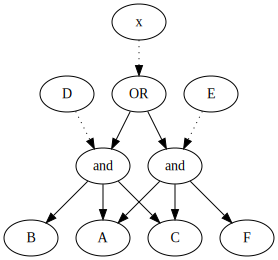

In [ ]:
#| echo: false
show_svg('naive_term_graph.svg')

The weakness with this approach is that `A AND C` is computed twice.

A version of the term graph that takes care to merge terms with overlapping structures would look more like this:
<!--
 digraph G {
   D_and [label="and"]
   E_and [label="and"]
   x->OR [style=dotted]
   E->E_and [style=dotted]
   D->D_and [style=dotted]
   OR -> {D_and,E_and}
   D_and ->{and,B}
   E_and -> {and,F} 
   and -> {A,C}
 }
 -->

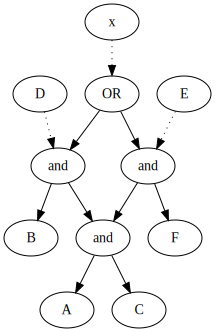

In [ ]:
#| echo: false
show_svg('shared_term_graph.svg')

Here, we realized that A,C is a joint component and that we need only compute it once.
This would be the automatic equivalent of a smart programmer, refactoring the query above to look like

```
>>> TEMP(X,Y,Z) <- A(X), C(X,Y,Z)
>>> D(X,Y) <- B(Y),TEMP(X,Y,Z)
>>> E(X,Y) <- TEMP(X,Y,Z), F(Z)
>>> x(X,Y) <- E(X,Y)
>>> x(X,Y) <- D(X,Y)
```

Here's a pseudo implementation of this pass: 
```
1. get all the registered rules by using term_graph.get_all_rules).

2. find overlapping structure between rules (this step can be implemented in many different ways).

3. create new rule that consists of the overlapping structure.

4. add this new rule to the term graph by using term_graph.add_rule_to_term_graph.

5. updated the previous rule to use the newly created rule.

6. added the rules to the term graph.

7. delete the previous versions of the rule from the term graph by using term_graph.remove_rule.
```

For example, 
if the following rules were registered:
1. ```D(X,Y) <- A(X),B(Y),C(X,Y,Z)```
2. ```E(X,Y) <- A(X),C(X,Y,Z), F(Z)```

In the second step of the algorithm, we will find that both rules share the structure ```A(X),C(X,Y,Z)```.<br>
In the third step we will create a new relation ```TEMP(X,Y,Z) <- A(X), C(X,Y,Z)```, and add it to the term graph.<br>
In the fifth step we will modify to original rules in the following way:
1. ```D(X,Y) <- B(Y),TEMP(X,Y,Z)```
2. ```E(X,Y) <- TEMP(X,Y,Z), F(Z)```

And then we will add them to the term graph.<br>
The last step will delete the old rules from the term graph.